In [1]:
import numpy as np  
import pandas as pd 
import os 

input_dir = '/kaggle/input'
file_paths = []

for dirname, _, filenames in os.walk(input_dir):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        file_paths.append(file_path)

print("Total files found:", len(file_paths))
print("files:", file_paths[:])  

expected_files = ['trainLabels.csv.zip', 'sampleSubmission.csv.zip']
for ef in expected_files:
    if not any(ef in path for path in file_paths):
        print(f"Warning: Expected file {ef} not found!")


Total files found: 23
files: ['/kaggle/input/diabetic-retinopathy-detection/train.zip.003', '/kaggle/input/diabetic-retinopathy-detection/test.zip.004', '/kaggle/input/diabetic-retinopathy-detection/test.zip.005', '/kaggle/input/diabetic-retinopathy-detection/train.zip.002', '/kaggle/input/diabetic-retinopathy-detection/test.zip.006', '/kaggle/input/diabetic-retinopathy-detection/test.zip.003', '/kaggle/input/diabetic-retinopathy-detection/train.zip.005', '/kaggle/input/diabetic-retinopathy-detection/train.zip.001', '/kaggle/input/diabetic-retinopathy-detection/sampleSubmission.csv.zip', '/kaggle/input/diabetic-retinopathy-detection/test.zip.007', '/kaggle/input/diabetic-retinopathy-detection/trainLabels.csv.zip', '/kaggle/input/diabetic-retinopathy-detection/test.zip.001', '/kaggle/input/diabetic-retinopathy-detection/sample.zip', '/kaggle/input/diabetic-retinopathy-detection/train.zip.004', '/kaggle/input/diabetic-retinopathy-detection/test.zip.002', '/kaggle/input/prepossessed-array

In [2]:
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import tensorflow as tf 
from glob import glob  
from skimage.io import imread  

from tensorflow.keras.applications import EfficientNetB0 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import SparseCategoricalCrossentropy  
from tensorflow.keras.layers import Dense, Flatten, Dropout  
from tensorflow.keras.models import Model  
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping  
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.utils import to_categorical  
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split 

import warnings
warnings.filterwarnings('ignore', category=FutureWarning) 

print("All necessary modules have been successfully imported!")


2024-08-28 07:31:50.190223: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 07:31:50.190408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 07:31:50.373820: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All necessary modules have been successfully imported!


In [3]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

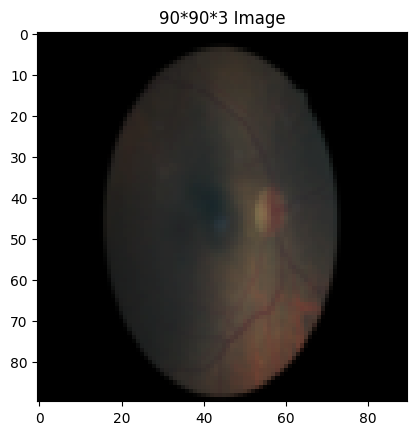

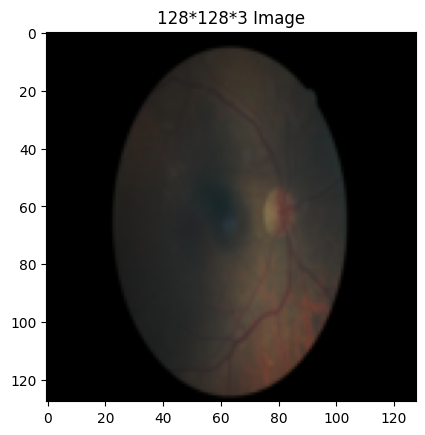

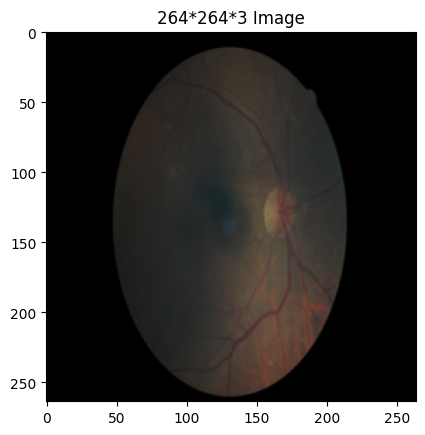

In [4]:
# Loading data
info = pd.read_csv("../input/prepossessed-arrays-of-binary-data/1000_Binary Dataframe")
info = info.drop('Unnamed: 0', axis=1)
Binary_90 = np.load('../input/prepossessed-arrays-of-binary-data/1000_Binary_images_data_90.npz')
X_90 = Binary_90['a']
Binary_128 = np.load('../input/prepossessed-arrays-of-binary-data/1000_Binary_images_data_128.npz')
X_128 = Binary_128['a']
Binary_264 = np.load('../input/prepossessed-arrays-of-binary-data/1000_Binary_images_data_264.npz')
X_264 = Binary_264['a']
y = info['level'].values

# Reshape images
X_90 = X_90.reshape(1000, 90, 90, 3)
X_128 = X_128.reshape(1000, 128, 128, 3)
X_264 = X_264.reshape(1000, 264, 264, 3)

# Display images
plt.title("90*90*3 Image")
plt.imshow(X_90[1])
plt.show()

plt.title("128*128*3 Image")
plt.imshow(X_128[1])
plt.show()

plt.title("264*264*3 Image")
plt.imshow(X_264[1])
plt.show()

In [5]:
# Prepare data for training
X = np.array(X_264)
Y = np.array(y)
Y = to_categorical(Y, 5)
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.5, random_state=42)

print(f"Training set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")
print(f"Test set size: {len(x_test)}")

Training set size: 600
Validation set size: 200
Test set size: 200


In [6]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

callbacks = [reduce_lr, early_stopping]

In [8]:
# Model with transfer learning (VGG16)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn import metrics  
Functional API 
input_shape = (264, 264, 3)
inputs = Input(shape=input_shape)


base_model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)


for layer in base_model.layers:
    layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)


model = Model(inputs, outputs)


model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])


model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 264, 264, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 264, 264, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 264, 264, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 132, 132, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 132, 132, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 132, 132, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 66, 66, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 66, 66, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 66, 66, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 66, 66, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 33, 33, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 33, 33, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 33, 33, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 33, 33, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,104,837 (88.14 MB)

 Trainable params: 8,390,149 (32.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
# Train the model

history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=8),
    validation_data=val_datagen.flow(x_val, y_val),
    epochs=20,
    callbacks=callbacks,
)

# Evaluate the model
evaluation = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {evaluation[1]*100:.2f}%')

# Predictions and report
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(model.predict(x_test), axis=-1)

print("Performance Report:")
print('Accuracy score:', metrics.accuracy_score(y_test_labels, y_pred_labels))
print('Precision score:', metrics.precision_score(y_test_labels, y_pred_labels, average='weighted'))
print('Recall score:', metrics.recall_score(y_test_labels, y_pred_labels, average='weighted'))
print('F1 Score:', metrics.f1_score(y_test_labels, y_pred_labels, average='weighted'))
print('Cohen Kappa Score:', metrics.cohen_kappa_score(y_test_labels, y_pred_labels))
print('\t\tClassification Report:\n', classification_report(y_test_labels, y_pred_labels))

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 342s 5s/step - AUC: 0.8884 - accuracy: 0.5996 - loss: 4.5692 - val_AUC: 0.9325 - val_accuracy: 0.7300 - val_loss: 1.7256 - learning_rate: 1.0000e-04
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 334s 4s/step - AUC: 0.9224 - accuracy: 0.6799 - loss: 1.5882 - val_AUC: 0.9325 - val_accuracy: 0.7300 - val_loss: 1.0638 - learning_rate: 1.0000e-04
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 337s 4s/step - AUC: 0.9158 - accuracy: 0.6530 - loss: 1.1244 - val_AUC: 0.9325 - val_accuracy: 0.7300 - val_loss: 0.9764 - learning_rate: 1.0000e-04
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 346s 5s/step - AUC: 0.9299 - accuracy: 0.6973 - loss: 0.9907 - val_AUC: 0.9325 - val_accuracy: 0.7300 - val_loss: 0.8887 - learning_rate: 1.0000e-04
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 341s 5s/step - AUC: 0.9429 - accuracy: 0.7420 - loss: 0.8801 - val_AUC: 0.9325 - val_accuracy: 0.7300 - val_loss: 0.8499 - learning_rate: 1.0000e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 339s 5s/step - AUC: 0.9309 - accuracy:

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

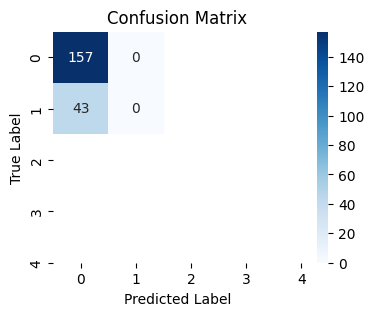

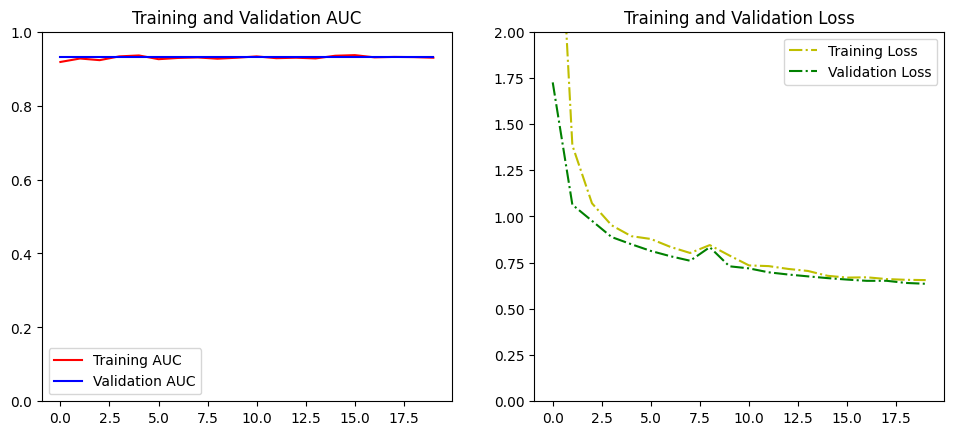

In [10]:
import matplotlib.pyplot as plt

# Confusion Matrix visualization
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Extracting the metrics using correct keys
auc = history.history['AUC']
val_auc = history.history['val_AUC']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the metrics
epochs = range(len(auc))
plt.figure(figsize=(18, 4.8))

# Plotting Training and Validation AUC
plt.subplot(1, 3, 1)
plt.plot(epochs, auc, 'r', label='Training AUC')
plt.plot(epochs, val_auc, 'b', label='Validation AUC')
plt.ylim(0, 1)
plt.title('Training and Validation AUC')
plt.legend(loc=0)

# Plotting Training and Validation Loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, 'y-.', label='Training Loss')
plt.plot(epochs, val_loss, 'g-.', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylim(0, 2)
plt.legend(loc=0)

plt.show()

In [12]:
y_pred_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])